# RNN实现情感分类

[![在线运行](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_modelarts.svg)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9yMi4yL3R1dG9yaWFscy9hcHBsaWNhdGlvbi96aF9jbi9ubHAvbWluZHNwb3JlX3NlbnRpbWVudF9hbmFseXNpcy5pcHluYg==&imageid=4c43b3ad-9df7-4b83-a096-c775dc4ba243)&emsp;[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.2/tutorials/application/zh_cn/nlp/mindspore_sentiment_analysis.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.2/tutorials/application/zh_cn/nlp/mindspore_sentiment_analysis.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.2/tutorials/application/source_zh_cn/nlp/sentiment_analysis.ipynb)

## 概述

情感分类是自然语言处理中的经典任务，是典型的分类问题。本节使用MindSpore实现一个基于RNN网络的情感分类模型，实现如下的效果：

```text
输入: This film is terrible
正确标签: Negative
预测标签: Negative

输入: This film is great
正确标签: Positive
预测标签: Positive
```

## 数据准备

本节使用情感分类的经典数据集[IMDB影评数据集](https://ai.stanford.edu/~amaas/data/sentiment/)，数据集包含Positive和Negative两类，下面为其样例：

| Review  | Label  |
|:---|:---:|
| "Quitting" may be as much about exiting a pre-ordained identity as about drug withdrawal. As a rural guy coming to Beijing, class and success must have struck this young artist face on as an appeal to separate from his roots and far surpass his peasant parents' acting success. Troubles arise, however, when the new man is too new, when it demands too big a departure from family, history, nature, and personal identity. The ensuing splits, and confusion between the imaginary and the real and the dissonance between the ordinary and the heroic are the stuff of a gut check on the one hand or a complete escape from self on the other.  |  Negative |  
| This movie is amazing because the fact that the real people portray themselves and their real life experience and do such a good job it's like they're almost living the past over again. Jia Hongsheng plays himself an actor who quit everything except music and drugs struggling with depression and searching for the meaning of life while being angry at everyone especially the people who care for him most.  | Positive  |

此外，需要使用预训练词向量对自然语言单词进行编码，以获取文本的语义特征，本节选取[Glove](https://nlp.stanford.edu/projects/glove/)词向量作为Embedding。

### 数据下载模块

为了方便数据集和预训练词向量的下载，首先设计数据下载模块，实现可视化下载流程，并保存至指定路径。数据下载模块使用`requests`库进行http请求，并通过`tqdm`库对下载百分比进行可视化。此外针对下载安全性，使用IO的方式下载临时文件，而后保存至指定的路径并返回。

> `tqdm`和`requests`库需手动安装，命令如下：`pip install tqdm requests`

In [1]:
pip install tqdm requests

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/MindSpore/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import shutil
import requests
import tempfile
from tqdm import tqdm
from typing import IO
from pathlib import Path

# 指定保存路径为 `home_path/.mindspore_examples`
cache_dir = Path.home() / '.mindspore_examples'

def http_get(url: str, temp_file: IO):
    """使用requests库下载数据，并使用tqdm库进行流程可视化"""
    req = requests.get(url, stream=True)
    content_length = req.headers.get('Content-Length')
    total = int(content_length) if content_length is not None else None
    progress = tqdm(unit='B', total=total)
    for chunk in req.iter_content(chunk_size=1024):
        if chunk:
            progress.update(len(chunk))
            temp_file.write(chunk)
    progress.close()

def download(file_name: str, url: str):
    """下载数据并存为指定名称"""
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    cache_path = os.path.join(cache_dir, file_name)
    cache_exist = os.path.exists(cache_path)
    if not cache_exist:
        with tempfile.NamedTemporaryFile() as temp_file:
            http_get(url, temp_file)
            temp_file.flush()
            temp_file.seek(0)
            with open(cache_path, 'wb') as cache_file:
                shutil.copyfileobj(temp_file, cache_file)
    return cache_path

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


完成数据下载模块后，下载IMDB数据集进行测试(此处使用华为云的镜像用于提升下载速度)。下载过程及保存的路径如下：

In [3]:
imdb_path = download('aclImdb_v1.tar.gz', 'https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/aclImdb_v1.tar.gz')
imdb_path

'/home/ma-user/.mindspore_examples/aclImdb_v1.tar.gz'

### 加载IMDB数据集

下载好的IMDB数据集为`tar.gz`文件，我们使用Python的`tarfile`库对其进行读取，并将所有数据和标签分别进行存放。原始的IMDB数据集解压目录如下：

```text
    ├── aclImdb
    │   ├── imdbEr.txt
    │   ├── imdb.vocab
    │   ├── README
    │   ├── test
    │   └── train
    │         ├── neg
    │         ├── pos
    ...
```

数据集已分割为train和test两部分，且每部分包含neg和pos两个分类的文件夹，因此需分别train和test进行读取并处理数据和标签。

In [4]:
import re
import six
import string
import tarfile

class IMDBData():
    """IMDB数据集加载器

    加载IMDB数据集并处理为一个Python迭代对象。

    """
    label_map = {
        "pos": 1,
        "neg": 0
    }
    def __init__(self, path, mode="train"):
        self.mode = mode
        self.path = path
        self.docs, self.labels = [], []

        self._load("pos")
        self._load("neg")

    def _load(self, label):
        pattern = re.compile(r"aclImdb/{}/{}/.*\.txt$".format(self.mode, label))
        # 将数据加载至内存
        with tarfile.open(self.path) as tarf:
            tf = tarf.next()
            while tf is not None:
                if bool(pattern.match(tf.name)):
                    # 对文本进行分词、去除标点和特殊字符、小写处理
                    self.docs.append(str(tarf.extractfile(tf).read().rstrip(six.b("\n\r"))
                                         .translate(None, six.b(string.punctuation)).lower()).split())
                    self.labels.append([self.label_map[label]])
                tf = tarf.next()

    def __getitem__(self, idx):
        return self.docs[idx], self.labels[idx]

    def __len__(self):
        return len(self.docs)

完成IMDB数据加载器后，加载训练数据集进行测试，输出数据集数量：

In [5]:
imdb_train = IMDBData(imdb_path, 'train')
len(imdb_train)

25000

将IMDB数据集加载至内存并构造为迭代对象后，可以使用`mindspore.dataset`提供的`Generatordataset`接口加载数据集迭代对象，并进行下一步的数据处理，下面封装一个函数将train和test分别使用`Generatordataset`进行加载，并指定数据集中文本和标签的`column_name`分别为`text`和`label`:

In [6]:
import mindspore.dataset as ds

def load_imdb(imdb_path):
    imdb_train = ds.GeneratorDataset(IMDBData(imdb_path, "train"), column_names=["text", "label"], shuffle=True)
    imdb_test = ds.GeneratorDataset(IMDBData(imdb_path, "test"), column_names=["text", "label"], shuffle=False)
    return imdb_train, imdb_test

加载IMDB数据集，可以看到`imdb_train`是一个GeneratorDataset对象。

In [7]:
imdb_train, imdb_test = load_imdb(imdb_path)
imdb_train

### 加载预训练词向量

预训练词向量是对输入单词的数值化表示，通过`nn.Embedding`层，采用查表的方式，输入单词对应词表中的index，获得对应的表达向量。
因此进行模型构造前，需要将Embedding层所需的词向量和词表进行构造。这里我们使用Glove(Global Vectors for Word Representation)这种经典的预训练词向量，
其数据格式如下：

| Word |  Vector |  
|:---|:---:|
| the | 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 ...|
| , | 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 ... |

我们直接使用第一列的单词作为词表，使用`dataset.text.Vocab`将其按顺序加载；同时读取每一行的Vector并转为`numpy.array`，用于`nn.Embedding`加载权重使用。具体实现如下：

In [8]:
import zipfile
import numpy as np

def load_glove(glove_path):
    glove_100d_path = os.path.join(cache_dir, 'glove.6B.100d.txt')
    if not os.path.exists(glove_100d_path):
        glove_zip = zipfile.ZipFile(glove_path)
        glove_zip.extractall(cache_dir)

    embeddings = []
    tokens = []
    with open(glove_100d_path, encoding='utf-8') as gf:
        for glove in gf:
            word, embedding = glove.split(maxsplit=1)
            tokens.append(word)
            embeddings.append(np.fromstring(embedding, dtype=np.float32, sep=' '))
    # 添加 <unk>, <pad> 两个特殊占位符对应的embedding
    embeddings.append(np.random.rand(100))
    embeddings.append(np.zeros((100,), np.float32))

    vocab = ds.text.Vocab.from_list(tokens, special_tokens=["<unk>", "<pad>"], special_first=False)
    embeddings = np.array(embeddings).astype(np.float32)
    return vocab, embeddings

由于数据集中可能存在词表没有覆盖的单词，因此需要加入`<unk>`标记符；同时由于输入长度的不一致，在打包为一个batch时需要将短的文本进行填充，因此需要加入`<pad>`标记符。完成后的词表长度为原词表长度+2。

下面下载Glove词向量，并加载生成词表和词向量权重矩阵。

In [9]:
glove_path = download('glove.6B.zip', 'https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/glove.6B.zip')
vocab, embeddings = load_glove(glove_path)
len(vocab.vocab())

400002

使用词表将`the`转换为index id，并查询词向量矩阵对应的词向量：

In [10]:
idx = vocab.tokens_to_ids('the')
embedding = embeddings[idx]
idx, embedding

(0,
 array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  0.7

## 数据集预处理

通过加载器加载的IMDB数据集进行了分词处理，但不满足构造训练数据的需要，因此要对其进行额外的预处理。其中包含的预处理如下：

- 通过Vocab将所有的Token处理为index id。
- 将文本序列统一长度，不足的使用`<pad>`补齐，超出的进行截断。

这里我们使用`mindspore.dataset`中提供的接口进行预处理操作。这里使用到的接口均为MindSpore的高性能数据引擎设计，每个接口对应操作视作数据流水线的一部分，详情请参考[MindSpore数据引擎](https://www.mindspore.cn/docs/zh-CN/r2.2/design/data_engine.html)。
首先针对token到index id的查表操作，使用`text.Lookup`接口，将前文构造的词表加载，并指定`unknown_token`。其次为文本序列统一长度操作，使用`PadEnd`接口，此接口定义最大长度和补齐值(`pad_value`)，这里我们取最大长度为500，填充值对应词表中`<pad>`的index id。

> 除了对数据集中`text`进行预处理外，由于后续模型训练的需要，要将`label`数据转为float32格式。

In [11]:
import mindspore as ms

lookup_op = ds.text.Lookup(vocab, unknown_token='<unk>')
pad_op = ds.transforms.PadEnd([500], pad_value=vocab.tokens_to_ids('<pad>'))
type_cast_op = ds.transforms.TypeCast(ms.float32)

完成预处理操作后，需将其加入到数据集处理流水线中，使用`map`接口对指定的column添加操作。

In [12]:
imdb_train = imdb_train.map(operations=[lookup_op, pad_op], input_columns=['text'])
imdb_train = imdb_train.map(operations=[type_cast_op], input_columns=['label'])

imdb_test = imdb_test.map(operations=[lookup_op, pad_op], input_columns=['text'])
imdb_test = imdb_test.map(operations=[type_cast_op], input_columns=['label'])

由于IMDB数据集本身不包含验证集，我们手动将其分割为训练和验证两部分，比例取0.7, 0.3。

In [13]:
imdb_train, imdb_valid = imdb_train.split([0.7, 0.3])

[WARNING] ME(30368:140294465910592,MainProcess):2025-12-13-17:37:06.263.855 [mindspore/dataset/engine/datasets.py:1145] Dataset is shuffled before split.


最后指定数据集的batch大小，通过`batch`接口指定，并设置是否丢弃无法被batch size整除的剩余数据。

> 调用数据集的`map`、`split`、`batch`为数据集处理流水线增加对应操作，返回值为新的Dataset类型。现在仅定义流水线操作，在执行时开始执行数据处理流水线，获取最终处理好的数据并送入模型进行训练。

In [14]:
imdb_train = imdb_train.batch(64, drop_remainder=True)
imdb_valid = imdb_valid.batch(64, drop_remainder=True)

## 模型构建

完成数据集的处理后，我们设计用于情感分类的模型结构。首先需要将输入文本(即序列化后的index id列表)通过查表转为向量化表示，此时需要使用`nn.Embedding`层加载Glove词向量；然后使用RNN循环神经网络做特征提取；最后将RNN连接至一个全连接层，即`nn.Dense`，将特征转化为与分类数量相同的size，用于后续进行模型优化训练。整体模型结构如下：

```text
nn.Embedding -> nn.RNN -> nn.Dense
```

这里我们使用能够一定程度规避RNN梯度消失问题的变种LSTM(Long short-term memory)做特征提取层。下面对模型进行详解：

### Embedding

Embedding层又可称为EmbeddingLookup层，其作用是使用index id对权重矩阵对应id的向量进行查找，当输入为一个由index id组成的序列时，则查找并返回一个相同长度的矩阵，例如：

```text
embedding = nn.Embedding(1000, 100) # 词表大小(index的取值范围)为1000，表示向量的size为100
input shape: (1, 16)                # 序列长度为16
output shape: (1, 16, 100)
```

这里我们使用前文处理好的Glove词向量矩阵，设置`nn.Embedding`的`embedding_table`为预训练词向量矩阵。对应的`vocab_size`为词表大小400002，`embedding_size`为选用的`glove.6B.100d`向量大小，即100。

### RNN(循环神经网络)

循环神经网络（Recurrent Neural Network, RNN）是一类以序列（sequence）数据为输入，在序列的演进方向进行递归（recursion）且所有节点（循环单元）按链式连接的神经网络。下图为RNN的一般结构：

![RNN-0](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/tutorials/application/source_zh_cn/nlp/images/0-RNN-0.png)

> 图示左侧为一个RNN Cell循环，右侧为RNN的链式连接平铺。实际上不管是单个RNN Cell还是一个RNN网络，都只有一个Cell的参数，在不断进行循环计算中更新。

由于RNN的循环特性，和自然语言文本的序列特性(句子是由单词组成的序列)十分匹配，因此被大量应用于自然语言处理研究中。下图为RNN的结构拆解：

![RNN](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/tutorials/application/source_zh_cn/nlp/images/0-RNN.png)

RNN单个Cell的结构简单，因此也造成了梯度消失(Gradient Vanishing)问题，具体表现为RNN网络在序列较长时，在序列尾部已经基本丢失了序列首部的信息。为了克服这一问题，LSTM(Long short-term memory)被提出，通过门控机制(Gating Mechanism)来控制信息流在每个循环步中的留存和丢弃。下图为LSTM的结构拆解：

![LSTM](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/tutorials/application/source_zh_cn/nlp/images/0-LSTM.png)

本节我们选择LSTM变种而不是经典的RNN做特征提取，来规避梯度消失问题，并获得更好的模型效果。下面来看MindSpore中`nn.LSTM`对应的公式：

$$h_{0:t}, (h_t, c_t) = \text{LSTM}(x_{0:t}, (h_0, c_0))$$

这里`nn.LSTM`隐藏了整个循环神经网络在序列时间步(Time step)上的循环，送入输入序列、初始状态，即可获得每个时间步的隐状态(hidden state)拼接而成的矩阵，以及最后一个时间步对应的隐状态。我们使用最后的一个时间步的隐状态作为输入句子的编码特征，送入下一层。

> Time step：在循环神经网络计算的每一次循环，成为一个Time step。在送入文本序列时，一个Time step对应一个单词。因此在本例中，LSTM的输出$h_{0:t}$对应每个单词的隐状态集合，$h_t$和$c_t$对应最后一个单词对应的隐状态。

### Dense

在经过LSTM编码获取句子特征后，将其送入一个全连接层，即`nn.Dense`，将特征维度变换为二分类所需的维度1，经过Dense层后的输出即为模型预测结果。

In [23]:
import math
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore.common.initializer import Uniform, HeUniform

class RNN(nn.Cell):
    def __init__(self, embeddings, hidden_dim, output_dim, n_layers,
                 bidirectional, pad_idx):
        super().__init__()
        vocab_size, embedding_dim = embeddings.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim, embedding_table=ms.Tensor(embeddings), padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           batch_first=True)
        weight_init = HeUniform(math.sqrt(5))
        bias_init = Uniform(1 / math.sqrt(hidden_dim * 2))
        self.fc = nn.Dense(hidden_dim * 2, output_dim, weight_init=weight_init, bias_init=bias_init)

    def construct(self, inputs):
        embedded = self.embedding(inputs)
        _, (hidden, _) = self.rnn(embedded)
        hidden = ops.concat((hidden[-2, :, :], hidden[-1, :, :]), axis=1)
        output = self.fc(hidden)
        return output

### 损失函数与优化器

完成模型主体构建后，首先根据指定的参数实例化网络；然后选择损失函数和优化器。针对本节情感分类问题的特性，即预测Positive或Negative的二分类问题，我们选择`nn.BCEWithLogitsLoss`(二分类交叉熵损失函数)。

In [24]:
hidden_size = 256
output_size = 1
num_layers = 2
bidirectional = True
lr = 0.001
pad_idx = vocab.tokens_to_ids('<pad>')

model = RNN(embeddings, hidden_size, output_size, num_layers, bidirectional, pad_idx)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = nn.Adam(model.trainable_params(), learning_rate=lr)

### 训练逻辑

在完成模型构建，进行训练逻辑的设计。一般训练逻辑分为一下步骤：

1. 读取一个Batch的数据；
2. 送入网络，进行正向计算和反向传播，更新权重；
3. 返回loss。

下面按照此逻辑，使用`tqdm`库，设计训练一个epoch的函数，用于训练过程和loss的可视化。

In [25]:
def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss

grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)

def train_step(data, label):
    loss, grads = grad_fn(data, label)
    optimizer(grads)
    return loss

def train_one_epoch(model, train_dataset, epoch=0):
    model.set_train()
    total = train_dataset.get_dataset_size()
    loss_total = 0
    step_total = 0
    with tqdm(total=total) as t:
        t.set_description('Epoch %i' % epoch)
        for i in train_dataset.create_tuple_iterator():
            loss = train_step(*i)
            loss_total += loss.asnumpy()
            step_total += 1
            t.set_postfix(loss=loss_total/step_total)
            t.update(1)

### 评估指标和逻辑

训练逻辑完成后，需要对模型进行评估。即使用模型的预测结果和测试集的正确标签进行对比，求出预测的准确率。由于IMDB的情感分类为二分类问题，对预测值直接进行四舍五入即可获得分类标签(0或1)，然后判断是否与正确标签相等即可。下面为二分类准确率计算函数实现：

In [26]:
def binary_accuracy(preds, y):
    """
    计算每个batch的准确率
    """

    # 对预测值进行四舍五入
    rounded_preds = np.around(ops.sigmoid(preds).asnumpy())
    correct = (rounded_preds == y).astype(np.float32)
    acc = correct.sum() / len(correct)
    return acc

有了准确率计算函数后，类似于训练逻辑，对评估逻辑进行设计, 分别为以下步骤：

1. 读取一个Batch的数据；
2. 送入网络，进行正向计算，获得预测结果；
3. 计算准确率。

同训练逻辑一样，使用`tqdm`进行loss和过程的可视化。此外返回评估loss至供保存模型时作为模型优劣的判断依据。

> 在进行evaluate时，使用的模型是不包含损失函数和优化器的网络主体；
> 在进行evaluate前，需要通过`model.set_train(False)`将模型置为评估状态，此时Dropout不生效。

In [27]:
def evaluate(model, test_dataset, criterion, epoch=0):
    total = test_dataset.get_dataset_size()
    epoch_loss = 0
    epoch_acc = 0
    step_total = 0
    model.set_train(False)

    with tqdm(total=total) as t:
        t.set_description('Epoch %i' % epoch)
        for i in test_dataset.create_tuple_iterator():
            predictions = model(i[0])
            loss = criterion(predictions, i[1])
            epoch_loss += loss.asnumpy()

            acc = binary_accuracy(predictions, i[1])
            epoch_acc += acc

            step_total += 1
            t.set_postfix(loss=epoch_loss/step_total, acc=epoch_acc/step_total)
            t.update(1)

    return epoch_loss / total

## 模型训练与保存

前序完成了模型构建和训练、评估逻辑的设计，下面进行模型训练。这里我们设置训练轮数为5轮。同时维护一个用于保存最优模型的变量`best_valid_loss`，根据每一轮评估的loss值，取loss值最小的轮次，将模型进行保存。

In [29]:
num_epochs = 5
best_valid_loss = float('inf')
ckpt_file_name = os.path.join(cache_dir, 'sentiment-analysis.ckpt')

for epoch in range(num_epochs):
    train_one_epoch(model, imdb_train, epoch)
    valid_loss = evaluate(model, imdb_valid, loss_fn, epoch)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        ms.save_checkpoint(model, ckpt_file_name)

Epoch 4: 100%|██████████| 117/117 [00:20<00:00,  5.63it/s, acc=0.968, loss=0.0977]


可以看到每轮Loss逐步下降，在验证集上的准确率逐步提升。

## 模型加载与测试

模型训练完成后，一般需要对模型进行测试或部署上线，此时需要加载已保存的最优模型(即checkpoint)，供后续测试使用。这里我们直接使用MindSpore提供的Checkpoint加载和网络权重加载接口：1.将保存的模型Checkpoint加载到内存中，2.将Checkpoint加载至模型。

> `load_param_into_net`接口会返回模型中没有和Checkpoint匹配的权重名，正确匹配时返回空列表。

In [30]:
param_dict = ms.load_checkpoint(ckpt_file_name)
ms.load_param_into_net(model, param_dict)

([], [])

对测试集打batch，然后使用evaluate方法进行评估，得到模型在测试集上的效果。

In [1]:
imdb_test = imdb_test.batch(64)
evaluate(model, imdb_test, loss_fn)

NameError: name 'imdb_test' is not defined

## 自定义输入测试

最后我们设计一个预测函数，实现开头描述的效果，输入一句评价，获得评价的情感分类。具体包含以下步骤:

1. 将输入句子进行分词；
2. 使用词表获取对应的index id序列；
3. index id序列转为Tensor；
4. 送入模型获得预测结果；
5. 打印输出预测结果。

具体实现如下：

In [32]:
score_map = {
    1: "Positive",
    0: "Negative"
}

def predict_sentiment(model, vocab, sentence):
    model.set_train(False)
    tokenized = sentence.lower().split()
    indexed = vocab.tokens_to_ids(tokenized)
    tensor = ms.Tensor(indexed, ms.int32)
    tensor = tensor.expand_dims(0)
    prediction = model(tensor)
    return score_map[int(np.round(ops.sigmoid(prediction).asnumpy()))]

最后我们预测开头的样例，可以看到模型可以很好地将评价语句的情感进行分类。

In [33]:
predict_sentiment(model, vocab, "This film is terrible")

'Negative'

In [ ]:
predict_sentiment(model, vocab, "This film is great")

'Positive'

## 额外对比实验：GRU与LSTM差别是什么？



In [17]:
import os
import math
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore.common.initializer import Uniform, HeUniform
import matplotlib.pyplot as plt
from tqdm import tqdm


# =========================================================
# 1) 你的 LSTM 模型（你原来的 RNN 类：内部是 nn.LSTM）
# =========================================================
class RNN(nn.Cell):
    def __init__(self, embeddings, hidden_dim, output_dim, n_layers,
                 bidirectional, pad_idx):
        super().__init__()
        vocab_size, embedding_dim = embeddings.shape
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(
            vocab_size, embedding_dim,
            embedding_table=ms.Tensor(embeddings, ms.float32),
            padding_idx=pad_idx
        )

        self.rnn = nn.LSTM(
            embedding_dim, hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            batch_first=True
        )

        fc_in = hidden_dim * 2 if bidirectional else hidden_dim
        weight_init = HeUniform(math.sqrt(5))
        bias_init = Uniform(1 / math.sqrt(fc_in))
        self.fc = nn.Dense(fc_in, output_dim, weight_init=weight_init, bias_init=bias_init)

    def construct(self, inputs):
        embedded = self.embedding(inputs)
        _, (hidden, _) = self.rnn(embedded)

        if self.bidirectional:
            hidden = ops.concat((hidden[-2, :, :], hidden[-1, :, :]), axis=1)
        else:
            hidden = hidden[-1, :, :]

        output = self.fc(hidden)
        return output


# =========================
# 用 GRU 替代 VanillaRNN
# =========================
class GRUModel(nn.Cell):
    def __init__(self, embeddings, hidden_dim, output_dim, n_layers,
                 bidirectional, pad_idx):
        super().__init__()
        vocab_size, embedding_dim = embeddings.shape
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(
            vocab_size, embedding_dim,
            embedding_table=ms.Tensor(embeddings, ms.float32),
            padding_idx=pad_idx
        )

        self.rnn = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            batch_first=True
        )

        fc_in = hidden_dim * 2 if bidirectional else hidden_dim
        weight_init = HeUniform(math.sqrt(5))
        bias_init = Uniform(1 / math.sqrt(fc_in))
        self.fc = nn.Dense(fc_in, output_dim, weight_init=weight_init, bias_init=bias_init)

    def construct(self, inputs):
        embedded = self.embedding(inputs)   # [B, T, E]
        _, hidden = self.rnn(embedded)      # hidden: [L*D, B, H]

        if self.bidirectional:
            feat = ops.concat((hidden[-2, :, :], hidden[-1, :, :]), axis=1)  # [B, 2H]
        else:
            feat = hidden[-1, :, :]                                         # [B, H]

        return self.fc(feat)



# =========================================================
# 3) 你原来的 accuracy / evaluate（做了小修：y转numpy+展平）
# =========================================================
def binary_accuracy(preds, y):
    """
    计算每个batch的准确率
    """
    probs = ops.sigmoid(preds).asnumpy()
    rounded_preds = np.around(probs).reshape(-1)

    y_np = y.asnumpy().reshape(-1)
    correct = (rounded_preds == y_np).astype(np.float32)
    acc = correct.mean()
    return acc


def evaluate(model, test_dataset, criterion, epoch=0):
    total = test_dataset.get_dataset_size()
    epoch_loss = 0.0
    epoch_acc = 0.0
    step_total = 0
    model.set_train(False)

    with tqdm(total=total) as t:
        t.set_description('Valid %i' % epoch)
        for batch in test_dataset.create_tuple_iterator():
            data, label = batch[0], batch[1]

            predictions = model(data)
            loss = criterion(predictions, label)
            epoch_loss += float(loss.asnumpy())

            acc = binary_accuracy(predictions, label)
            epoch_acc += acc

            step_total += 1
            t.set_postfix(loss=epoch_loss/step_total, acc=epoch_acc/step_total)
            t.update(1)

    return (epoch_loss / max(total, 1)), (epoch_acc / max(total, 1))


# =========================================================
# 4) 关键：保持你写法的“构建 train_step”
# =========================================================
def build_train_step(model, loss_fn, optimizer):
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    def train_step(data, label):
        (loss, logits), grads = grad_fn(data, label)
        optimizer(grads)
        return loss, logits

    return train_step


def train_one_epoch(model, train_dataset, epoch, train_step_fn):
    model.set_train()
    total = train_dataset.get_dataset_size()
    loss_total = 0.0
    acc_total = 0.0
    step_total = 0

    with tqdm(total=total) as t:
        t.set_description('Train %i' % epoch)
        for batch in train_dataset.create_tuple_iterator():
            data, label = batch[0], batch[1]

            loss, logits = train_step_fn(data, label)
            loss_total += float(loss.asnumpy())
            acc_total += binary_accuracy(logits, label)

            step_total += 1
            t.set_postfix(loss=loss_total/step_total, acc=acc_total/step_total)
            t.update(1)

    return (loss_total / max(step_total, 1)), (acc_total / max(step_total, 1))


# =========================================================
# 5) 按你原循环：训练两个模型 + 画对比图 + 保存ckpt
# =========================================================
hidden_size = 256
output_size = 1
num_layers = 2
bidirectional = True
lr = 0.001
pad_idx = vocab.tokens_to_ids('<pad>')

num_epochs = 5
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

# 两个模型
lstm_model = RNN(embeddings, hidden_size, output_size, num_layers, bidirectional, pad_idx)
gru_model  = GRUModel(embeddings, hidden_size, output_size, num_layers, bidirectional, pad_idx)

# 两个优化器 & train_step
lstm_opt = nn.Adam(lstm_model.trainable_params(), learning_rate=lr)
gru_opt  = nn.Adam(gru_model.trainable_params(), learning_rate=lr)

lstm_train_step = build_train_step(lstm_model, loss_fn, lstm_opt)
gru_train_step = build_train_step(gru_model, loss_fn, gru_opt)

# 记录曲线
hist = {
    "lstm_train_loss": [], "lstm_valid_loss": [], "lstm_valid_acc": [],
    "gru_train_loss":  [], "gru_valid_loss":  [], "gru_valid_acc":  [],
}

best_lstm_valid = float('inf')
best_gru_valid  = float('inf')

lstm_ckpt = os.path.join(cache_dir, 'sentiment-analysis-lstm.ckpt')
gru_ckpt = os.path.join(cache_dir, 'sentiment-analysis-gru.ckpt')


for epoch in range(num_epochs):
    # ---- LSTM ----
    tr_loss, tr_acc = train_one_epoch(lstm_model, imdb_train, epoch, lstm_train_step)
    va_loss, va_acc = evaluate(lstm_model, imdb_valid, loss_fn, epoch)

    hist["lstm_train_loss"].append(tr_loss)
    hist["lstm_valid_loss"].append(va_loss)
    hist["lstm_valid_acc"].append(va_acc)

    if va_loss < best_lstm_valid:
        best_lstm_valid = va_loss
        ms.save_checkpoint(lstm_model, lstm_ckpt)

    # ---- GRU ----
    tr_loss, tr_acc = train_one_epoch(gru_model, imdb_train, epoch, gru_train_step)
    va_loss, va_acc = evaluate(gru_model, imdb_valid, loss_fn, epoch)

    hist["gru_train_loss"].append(tr_loss)
    hist["gru_valid_loss"].append(va_loss)
    hist["gru_valid_acc"].append(va_acc)

    if va_loss < best_gru_valid:
        best_gru_valid = va_loss
        ms.save_checkpoint(gru_model, gru_ckpt)

print("Best ckpt:")
print(" - LSTM:", lstm_ckpt, "best_valid_loss=", best_lstm_valid)
print(" - GRU :", gru_ckpt,  "best_valid_loss=", best_gru_valid)

# =========================================================
# 6) 画对比图：train/valid loss + 最终 acc
# =========================================================
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, hist["lstm_train_loss"], label="LSTM Train Loss")
plt.plot(epochs, hist["lstm_valid_loss"], label="LSTM Valid Loss")
plt.plot(epochs, hist["gru_train_loss"],  label="GRU Train Loss")
plt.plot(epochs, hist["gru_valid_loss"],  label="GRU Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves: LSTM vs GRU")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

final_lstm_acc = hist["lstm_valid_acc"][-1]
final_gru_acc  = hist["gru_valid_acc"][-1]

plt.figure(figsize=(6, 4))
plt.bar(["LSTM", "GRU"], [final_lstm_acc, final_gru_acc])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Final Valid Accuracy: LSTM vs GRU")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


Valid 4: 100%|██████████| 117/117 [00:13<00:00,  8.96it/s, acc=0.983, loss=0.0512]


Best ckpt:
 - LSTM: /home/ma-user/.mindspore_examples/sentiment-analysis-lstm.ckpt best_valid_loss= 0.18353575875616482


NameError: name 'rnn_ckpt' is not defined

Best ckpt:
 - LSTM: /home/ma-user/.mindspore_examples/sentiment-analysis-lstm.ckpt best_valid_loss= 0.18353575875616482
 - GRU : /home/ma-user/.mindspore_examples/sentiment-analysis-gru.ckpt best_valid_loss= 0.05123271877503293


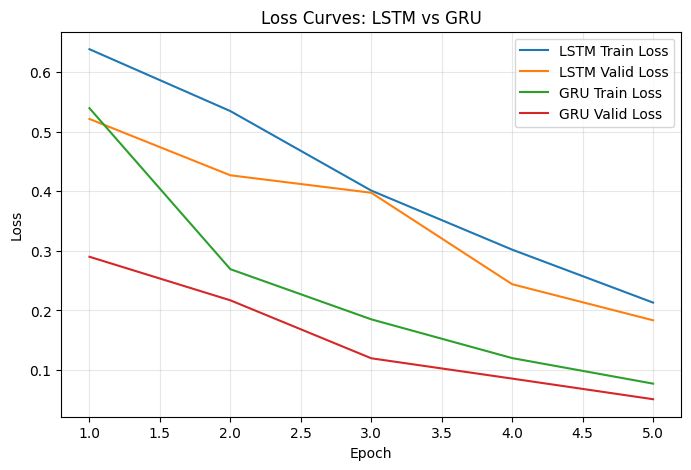

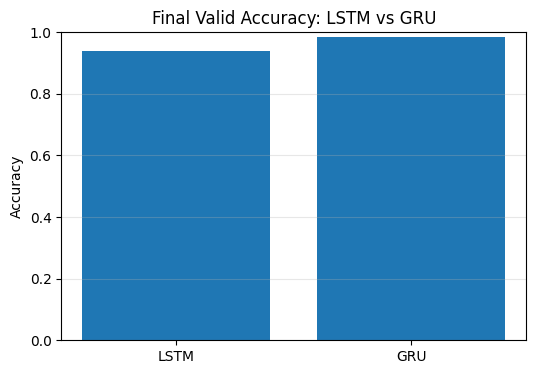

In [18]:
print("Best ckpt:")
print(" - LSTM:", lstm_ckpt, "best_valid_loss=", best_lstm_valid)
print(" - GRU :", gru_ckpt,  "best_valid_loss=", best_gru_valid)

# =========================================================
# 6) 画对比图：train/valid loss + 最终 acc
# =========================================================
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, hist["lstm_train_loss"], label="LSTM Train Loss")
plt.plot(epochs, hist["lstm_valid_loss"], label="LSTM Valid Loss")
plt.plot(epochs, hist["gru_train_loss"],  label="GRU Train Loss")
plt.plot(epochs, hist["gru_valid_loss"],  label="GRU Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves: LSTM vs GRU")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

final_lstm_acc = hist["lstm_valid_acc"][-1]
final_gru_acc  = hist["gru_valid_acc"][-1]

plt.figure(figsize=(6, 4))
plt.bar(["LSTM", "GRU"], [final_lstm_acc, final_gru_acc])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Final Valid Accuracy: LSTM vs GRU")
plt.grid(True, axis="y", alpha=0.3)
plt.show()
